# Descriptive analysis

tbc

## Set up

In [1]:
# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    notebook = '01'


paths = Paths()

In [4]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))

## Functions

In [5]:
def n_freq(series):
    '''
    Finds value counts and their frequency
    Input series e.g. data[col], data[[col1, col2]],
    data.groupby(col1)[col2]
    '''
    res = pd.concat(
        [series.value_counts(dropna=False),
         series.value_counts(dropna=False, normalize=True)],
        axis=1,
        keys=('n', 'freq'))
    if res.index.nlevels > 1:
        res = res.reset_index()
    return (res)

## Overview of dataset

In [6]:
# Show shape of the data
data.shape

(137019, 71)

In [7]:
# List all columns and show their data types and proportion of completed data
data_types = data.dtypes
completion = data.count() / data.shape[0]
data_info = pd.DataFrame({'Data type': data_types,
                          'Proportion complete': completion})

# Show dataframe
data_info

,Data type,Proportion complete
Unnamed: 0,int64,1.0
id,int64,1.0
stroke_team,object,1.0
age,float64,1.0
male,int64,1.0
...,...,...
thrombolysis_no_but_age,int64,1.0
thrombolysis_no_but_improving,int64,1.0
thrombolysis_no_but_too_mild_severe,int64,1.0
thrombolysis_no_but_time_unknown_wake_up,int64,1.0


In [8]:
# Printing change in number of records due to restricting years
print(f'''
Number of records per year:
{data.year.value_counts().sort_index().to_string()}''')


Number of records per year:
2016    22419
2017    23017
2018    22737
2019    23000
2020    22083
2021    23763


## Admissions

Restricted dataset

In [9]:
# Total admissions
len(data.index)

137019

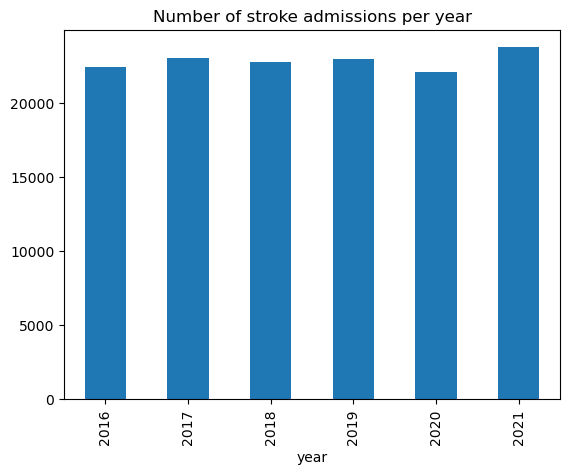

In [10]:
# Admissions per year
yearly_admissions = data.groupby('year').size().reset_index(name='admissions')
yearly_admissions.plot.bar(x='year', y='admissions',
                           title='Number of stroke admissions per year',
                           legend=None)
plt.show()

In [11]:
# Mean admissions per year
round(yearly_admissions['admissions'].mean(), 2)

22836.5

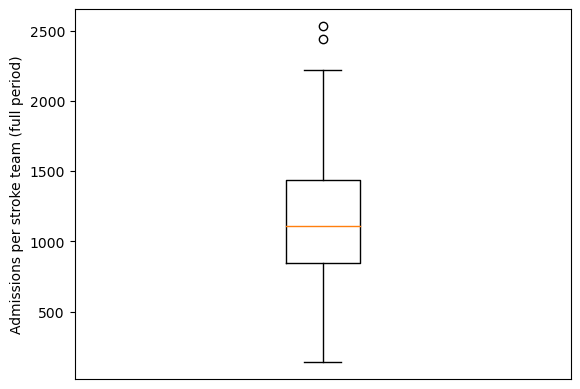

In [12]:
# Admissions per stroke team
team_admissions = data.groupby('stroke_team').size()

# Plot distribution of admissions
plt.boxplot(team_admissions)
plt.ylabel('Admissions per stroke team (full period)')

# Remove x axis ticks as only one variable
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

plt.show()

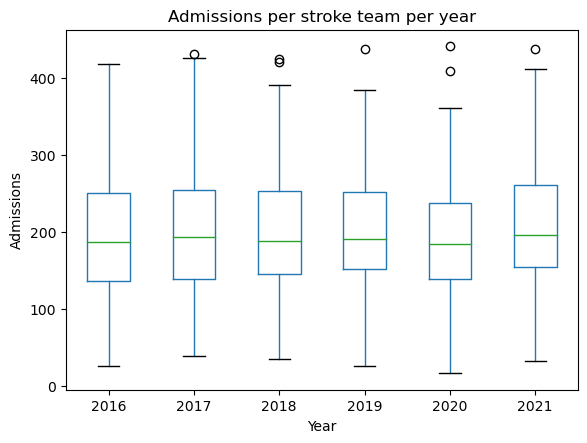

In [13]:
# Find number of admissions per stroke team per year
team_admissions_yearly = (data
                          .groupby(['stroke_team', 'year'])
                          .size()
                          .reset_index(name='admissions'))

# Plot per year
team_admissions_yearly.boxplot('admissions', by='year')
plt.xlabel('Year')
plt.ylabel('Admissions')
plt.title('Admissions per stroke team per year')
plt.suptitle('')
plt.grid(None)
plt.show()

## Stroke types

In [14]:
n_freq(data['infarction'].map({1: 'Infarction',
                               0: 'Primary Intracerebral Haemorrage'}))

,n,freq
Infarction,116985,0.853787
Primary Intracerebral Haemorrage,20034,0.146213


## Thrombolysis and thrombectomy

In [15]:
# Thrombolysis use
n_freq(data['thrombolysis'])

,n,freq
0,96964,0.707668
1,40055,0.292332


In [16]:
# Thrombectomy use
n_freq(data['thrombectomy'])

,n,freq
0,133535,0.974573
1,3484,0.025427


In [17]:
# Thrombolysis and/or thrombectomy use
n_freq(data[['thrombolysis', 'thrombectomy']]).sort_values(by='thrombolysis')

,thrombolysis,thrombectomy,n,freq
0,0,0,95953,0.700290
3,0,1,1011,0.007379
1,1,0,37582,0.274283
2,1,1,2473,0.018049


In [18]:
# Arrival by ambulance
n_freq(data['arrive_by_ambulance'])

,n,freq
1.0,123839,0.903809
0.0,13174,0.096147
NaN,6,0.000044


In [19]:
# Thrombolysis use, depending on whether arrived by ambulance
(n_freq(data.groupby('arrive_by_ambulance')['thrombolysis'])
 .sort_values(by='arrive_by_ambulance'))

,arrive_by_ambulance,thrombolysis,n,freq
0,0.0,0,10149,0.770381
1,0.0,1,3025,0.229619
2,1.0,0,86810,0.700991
3,1.0,1,37029,0.299009


## Reasons for no thrombolysis

It is possible to have multiple reasons why no thrombolysis was given.

To do:
* What are the most common reasons
* How often is it a combination of reasons
* How often is no reason provided
* Double-check this is only complete when there was no thrombolysis
* Look further (e.g. subgroups, characteristics, associations)

In [20]:
(data[[col for col in data if col.startswith('thrombolysis_no')]]
 .value_counts(dropna=False)
 .reset_index(name='count'))

,thrombolysis_no_not_available,thrombolysis_no_out_of_hours,thrombolysis_no_scan_not_quick_enough,thrombolysis_no_no_reason,thrombolysis_no_but_haemorrhagic,thrombolysis_no_but_time_window,thrombolysis_no_but_comorbidity,thrombolysis_no_but_medication,thrombolysis_no_but_refusal,thrombolysis_no_but_age,thrombolysis_no_but_improving,thrombolysis_no_but_too_mild_severe,thrombolysis_no_but_time_unknown_wake_up,thrombolysis_no_but_other_medical,count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40055
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,19947
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12966
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10838
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1
220,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
221,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1
222,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1


## Disability at 6 months

Currently, outcome models are just based on discharge disability. The majority of patients are missing disability at 6 months - but this is not likely to be missing at random.

In [21]:
# tbc
# e.g. disability at discharge v.s. at 6 months, is it typically 1 mRS better

### Comparing patients who arrived by ambulance to those who did not

In [22]:
# Find counts arriving by ambulance or not
arrive_ambulance_stats = (
    data['arrive_by_ambulance']
    .map({0: 'Did not arrive by ambulance', 1: 'Arrived by ambulance'})
    .value_counts(dropna=False)
    .reset_index(name='count'))

# Find proportions
arrive_ambulance_stats['percentage'] = (
    arrive_ambulance_stats['count'] /
    arrive_ambulance_stats['count'].sum()*100)

arrive_ambulance_stats

,index,count,percentage
0,Arrived by ambulance,123839,90.380896
1,Did not arrive by ambulance,13174,9.614725
2,NaN,6,0.004379


#### Prior disability

Patients who arrived by ambulance typically had more severe strokes.

In [23]:
(data
 .groupby('arrive_by_ambulance')['prior_disability']
 .describe())

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,13174.0,0.551465,1.016624,0.0,0.0,0.0,1.0,5.0
1.0,123839.0,1.098467,1.433088,0.0,0.0,0.0,2.0,5.0


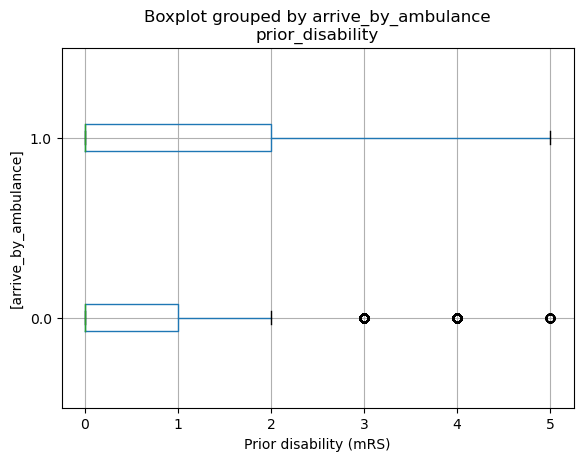

In [24]:
(data[['prior_disability', 'arrive_by_ambulance']]
 .boxplot(by='arrive_by_ambulance', vert=False))
plt.xlabel('Prior disability (mRS)')
plt.show()

,arrive_by_ambulance,prior_disability,count,proportion
0,0.0,0,9229,0.067359
1,0.0,1,2044,0.014918
2,0.0,2,863,0.006299
3,0.0,3,715,0.005218
4,0.0,4,265,0.001934
5,0.0,5,58,0.000423
6,1.0,0,66035,0.481962
7,1.0,1,19229,0.140344
8,1.0,3,15149,0.110566
9,1.0,2,12416,0.090619


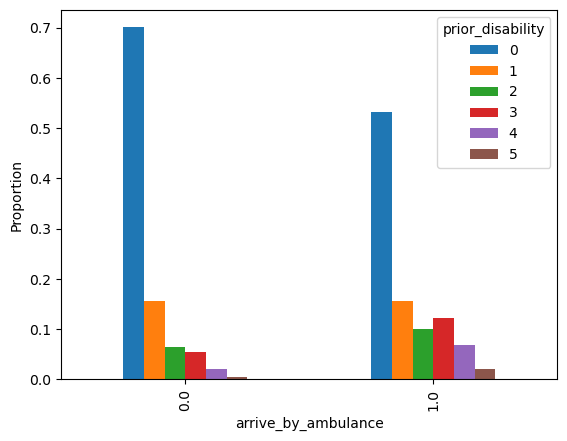

In [25]:
# Show counts and proportion of each mRS score
# (by whether arrived by ambulance)
amb_mrs = (data
           .groupby('arrive_by_ambulance')['prior_disability']
           .value_counts()
           .reset_index(name='count'))
amb_mrs['proportion'] = amb_mrs['count'] / amb_mrs['count'].sum()
display(amb_mrs)

# Create grouped bar plot based on proportions
(data
 .groupby('arrive_by_ambulance')['prior_disability']
 .value_counts(normalize=True)
 .unstack('prior_disability')
 .plot.bar())
plt.ylabel('Proportion')
plt.show()